Baseline with Bert  

I will eventually use dense retreival based models. This is simply a baseline. 

This BERT model is used for processing the abstract information from patent documents. 

In [1]:
import torch 
import torch.nn as nn 
import torch.functional as f 
from torch.optim import AdamW 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler 
from sklearn.model_selection import train_test_split 
import time 
import datetime 
import re 
import math 
import sklearn 
import os
import json 
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup

# Inspect Sample Data

In [2]:
files = os.listdir('sample_data')
print("number of sample files = {}".format(len(files)))

number of sample files = 597


In [3]:
with open('sample_data/'+files[0]) as f: 
    data = json.load(f) 
    print(data.keys())

dict_keys(['patent1id', 'patent2id', 'fullpatent1id', 'fullpatent2id', 'patent1abstract', 'patent2abstract', 'patent1claims', 'patent2claims'])


There are a few problematic json files. For now let's only use samples that we can parse. 

In [4]:
sample_train = [] 

for idx, file in enumerate(files): 
    filename = 'sample_data/' + file
    if '.json' not in filename: 
        continue
    try: 
        with open(filename) as f:  
            data = json.load(f) 
            sample_train.append(data)
    except Exception as e: 
        print("problem occured with file {}".format(file))
        print(e)

problem occured with file 12001003_4589656.json
Extra data: line 114 column 2 (char 25639)
problem occured with file 12001021_20060183900.json
Extra data: line 395 column 2 (char 126007)
problem occured with file 12000641_20070108429.json
Extra data: line 125 column 2 (char 30036)
problem occured with file 12000959_20050276053.json
Extra data: line 100 column 2 (char 14009)
problem occured with file 12000891_5700250.json
Extra data: line 85 column 2 (char 17949)
problem occured with file 12000822_20020020426.json
Extra data: line 427 column 2 (char 86260)
problem occured with file 12000618_20080055227.json
Extra data: line 141 column 2 (char 41587)
problem occured with file 12000491_3751333.json
Extra data: line 37 column 2 (char 5139)
problem occured with file 12000662_20040094050.json
Extra data: line 253 column 2 (char 63125)
problem occured with file 12000414_6913295.json
Extra data: line 73 column 2 (char 14197)
problem occured with file 12000811_20020033664.json
Extra data: line 

Of the features we have, we are going to use the patent1abstract, patent2abstract and patent1claims and patent2claims. 

We will build separate models for each pairs. 

In [5]:
sample_train[0].keys() 

dict_keys(['patent1id', 'patent2id', 'fullpatent1id', 'fullpatent2id', 'patent1abstract', 'patent2abstract', 'patent1claims', 'patent2claims'])

# Preprocess Data

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 

def BERT_Tokenizer(text, MAX_LEN=512): 
    encoded_dict = tokenizer.encode_plus(
        text = text,  
        add_special_tokens = True, 
        pad_to_max_length = False, 
        return_attention_mask = True 
    )
    input_id = encoded_dict['input_ids'] 
    attention_mask = encoded_dict['attention_mask'] 
    
    # get the first 512 tokens
    text_len = len(input_id)
    if len(input_id) > MAX_LEN: 
        input_id = input_id[:MAX_LEN] 
        attention_mask = attention_mask[:MAX_LEN] 
    else: 
        input_id = input_id + [0]*(MAX_LEN - len(input_id)) 
        attention_mask = attention_mask + [0]*(MAX_LEN - len(attention_mask)) 
    
    return input_id, attention_mask, text_len 


In [7]:
# store tokenzied abstract and claims 
abstract1_input_ids, abstract2_input_ids = [], [] 
abstract1_attention_masks, abstract2_attention_masks = [], [] 
abstract1_lengths, abstract2_lengths = [], [] 
labels = []  

for i in tqdm(range(len(sample_train)), position=0, leave=True): 
    a1 = sample_train[i]['patent1abstract'] 
    a2 = sample_train[i]['patent2abstract'] 
               
    a1_input_id, a1_attention_mask, a1_length = BERT_Tokenizer(a1)
    abstract1_input_ids.append(a1_input_id) 
    abstract1_attention_masks.append(a1_attention_mask)
    abstract1_lengths.append(a1_length)   
    
    a2_input_id, a2_attention_mask, a2_length = BERT_Tokenizer(a2) 
    abstract2_input_ids.append(a2_input_id)
    abstract2_attention_masks.append(a2_attention_mask) 
    abstract2_lengths.append(a2_length) 
    
    # sample data are all similar 
    labels.append(1)

100%|██████████| 560/560 [00:04<00:00, 132.66it/s]


In [8]:
def token_stats(arr):
    print("mean tokens = {}".format(np.mean(arr))) 
    print("min tokens = {}".format(np.min(arr))) 
    print("max tokens = {}".format(np.max(arr))) 
    print("number of data with more than 512 tokens = {}".format(np.sum(i > 512 for i in arr))) 
    print("percentage of data with more than 512 tokens = {:.2f}%".format(np.sum(i > 4096 for i in arr) * 100 / len(arr)))
    print()

In [9]:
token_stats(abstract1_lengths) 

token_stats(abstract2_lengths) 


mean tokens = 137.67857142857142
min tokens = 14
max tokens = 410
number of data with more than 512 tokens = 0
percentage of data with more than 512 tokens = 0.00%

mean tokens = 153.3125
min tokens = 24
max tokens = 360
number of data with more than 512 tokens = 0
percentage of data with more than 512 tokens = 0.00%



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [10]:
abstract1_input_ids = torch.tensor(abstract1_input_ids, dtype=int)
abstract1_attention_masks = torch.tensor(abstract1_attention_masks, dtype=int) 

abstract2_input_ids = torch.tensor(abstract2_input_ids, dtype=int)
abstract2_attention_masks = torch.tensor(abstract2_attention_masks, dtype=int) 

labels = torch.tensor(labels, dtype=float)
labels = torch.reshape(labels, (-1,1))

abstract1_input_ids.shape, abstract1_attention_masks.shape, abstract2_input_ids.shape, abstract2_attention_masks.shape, labels.shape

(torch.Size([560, 512]),
 torch.Size([560, 512]),
 torch.Size([560, 512]),
 torch.Size([560, 512]),
 torch.Size([560, 1]))

# Create DataLoader

In [11]:
train_abstract1_input_ids, val_abstract1_input_ids, train_abstract1_attention_masks, val_abstract1_attention_masks = train_test_split(abstract1_input_ids, 
                                                                                                                                      abstract1_attention_masks, 
                                                                                                                                      random_state = 888, 
                                                                                                                                      test_size = 0.1) 

train_abstract2_input_ids, val_abstract2_input_ids, train_abstract2_attention_masks, val_abstract2_attention_masks = train_test_split(abstract2_input_ids,
                                                                                                                                      abstract2_attention_masks, 
                                                                                                                                      random_state = 888, 
                                                                                                                                      test_size = 0.1)



_, _, train_labels, val_labels = train_test_split(abstract1_input_ids, 
                                                  labels, 
                                                  random_state = 888, 
                                                  test_size = 0.1)


train_abstract1_input_ids.shape, val_abstract1_input_ids.shape, train_abstract1_attention_masks.shape, val_abstract1_attention_masks.shape, train_abstract2_input_ids.shape, train_abstract2_attention_masks.shape, train_labels.shape, val_labels.shape


(torch.Size([504, 512]),
 torch.Size([56, 512]),
 torch.Size([504, 512]),
 torch.Size([56, 512]),
 torch.Size([504, 512]),
 torch.Size([504, 512]),
 torch.Size([504, 1]),
 torch.Size([56, 1]))

In [12]:
batch_size = 8
train_data = TensorDataset(train_abstract1_input_ids, 
                           train_abstract1_attention_masks, 
                           train_abstract2_input_ids,  
                           train_abstract2_attention_masks, 
                           train_labels) 

train_sampler = RandomSampler(train_data) 

train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)   

In [13]:
validation_data = TensorDataset(val_abstract1_input_ids, 
                                val_abstract1_attention_masks, 
                                val_abstract2_input_ids, 
                                val_abstract2_attention_masks, 
                                val_labels) 

val_sampler = SequentialSampler(validation_data)

val_dataloader = DataLoader(validation_data, sampler = val_sampler, batch_size = batch_size) 

# BERT Model that takes in abstract information

In [14]:
class BERT_ABSTRACT(nn.Module): 
    def __init__(self): 
        super(BERT_ABSTRACT, self).__init__()
        self.bert1 = BertModel.from_pretrained("bert-base-uncased") 
        self.bert2 = BertModel.from_pretrained("bert-base-uncased")
        self.fc1 = nn.Linear(768*2, 768) 
        self.batchnorm1 = nn.BatchNorm1d(768)
        self.fc2 = nn.Linear(768, 256) 
        self.batchnorm2 = nn.BatchNorm1d(256) 
        self.fc3 = nn.Linear(256, 1) 
        self.activation = nn.Sigmoid() 
    
    def forward(self, ids1, masks1, ids2, masks2): 
        outputs1 = self.bert1(input_ids = ids1, 
                              attention_mask = masks1) 
        pooler1 = outputs1.pooler_output 
        
        outputs2 = self.bert2(input_ids = ids2, 
                              attention_mask = masks2) 
        pooler2 = outputs2.pooler_output 
                
        x = torch.cat((pooler1, pooler2), 1) 
        fc1 = self.fc1(x) 
        bn1 = self.batchnorm1(fc1) 
        fc2 = self.fc2(bn1) 
        bn2 = self.batchnorm2(fc2) 
        fc3 = self.activation(self.fc3(bn2)) 
        return fc3 

In [15]:
model = BERT_ABSTRACT() 

model.cuda() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationsh

BERT_ABSTRACT(
  (bert1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

# Train

In [16]:
def flat_accuracy(preds, labels): 
    pred_flat = np.argmax(preds, axis=1).flatten() 
    labels_flat = labels.flatten() 
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed): 
    elapsed_rounded = int(round(elapsed)) 
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [17]:
class EarlyStopping: 
    ''' if validation loss does not decrease anymore, we stop training '''
    def __init__(self, patience, verbose, delta, path): 
        self.patience = patience 
        self.verbose = verbose 
        self.counter = 0 
        self.best_score = None 
        self.early_stop = False 
        self.val_loss_min = np.Inf 
        self.delta = delta 
        self.path = path 
    
    def __call__(self, val_loss, model): 
        score = -val_loss 
        if self.best_score is None:  
            self.best_score = score 
            self.save_checkpoint(val_loss, model) 
        elif score < self.best_score + self.delta: 
            self.counter += 1 
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience: 
                self.early_stop = True 
        else: 
            self.best_score = score 
            self.save_checkpoint(val_loss, model) 
            self.counter = 0 
    
    def save_checkpoint(self, val_loss, model): 
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [18]:
device = torch.device('cuda')

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 50

total_steps = len(train_dataloader) * epochs 

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

train_losses, val_losses = [], [] 
### binary crossentropy loss ### 
criterion = nn.BCELoss() 

### early stopping ### 
early_stopping = EarlyStopping(patience = 3, verbose = True, delta=0, path="BERT_ABSTRACT.pt")
tolerance = True 

### initialize gradient ###
model.zero_grad() 

for epoch_i in range(0, epochs):  
    ### Training ### 
    print("")
    print("===== Epoch {:} / {:} =====".format(epoch_i + 1, epochs))
    print("Training...")
    t0 = time.time() 
    total_loss = 0 
    model.train() 
    for step, batch in enumerate(train_dataloader): 
        if step%20 == 0 and not step == 0: 
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            print('  current average loss = {}'.format(total_loss / step))
        
        batch = tuple(t.to(device) for t in batch) 
        
        b_ids1, b_masks1, b_ids2, b_masks2, b_labels = batch 
        outputs = model(ids1 = b_ids1, 
                        masks1 = b_masks1, 
                        ids2 = b_ids2, 
                        masks2 = b_masks2) 
        

        
        loss = criterion(outputs.float(), b_labels.float()) 
        total_loss += loss.item() 
        loss.backward() 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        optimizer.step() 
        scheduler.step() 
        model.zero_grad() 
        
    avg_train_loss = total_loss / len(train_dataloader) 
    train_losses.append(avg_train_loss)
    print("")
    print(" Average Training Loss: {}".format(avg_train_loss)) 
    print(" Training epoch took: {:}".format(format_time(time.time() - t0))) 
    
    ### Validation ### 
    print("")
    print("Running Validation") 
    t0 = time.time() 
    model.eval() 
    
    eval_loss = 0 
    
    for batch in val_dataloader: 
        batch = tuple(t.to(device) for t in batch) 
        b_ids1, b_masks1, b_ids2, b_masks2, b_labels = batch 
        with torch.no_grad(): 
            outputs = model(ids1 = b_ids1, 
                            masks1 = b_masks1, 
                            ids2 = b_ids2, 
                            masks2 = b_masks2)
        
        loss = criterion(outputs.float(), b_labels.float())
        eval_loss += loss.item() 
        
    avg_val_loss = eval_loss / len(val_dataloader)  
    val_losses.append(avg_val_loss)
    print(" Average validation loss: {}".format(avg_val_loss))  
    if tolerance == True:  
        early_stopping(avg_val_loss, model) 
    elif tolerance == False: 
        if avg_val_loss == np.min(val_losses): 
            print("saving best checkpoint after early stopping!") 
            torch.save(model.state_dict(), "BERT_ABSTRACT_" + str(epoch_i))
    
    if early_stopping.early_stop: 
        print("We are out of patience") 
        tolerance = False 


===== Epoch 1 / 50 =====
Training...
  Batch    20  of     63.    Elapsed: 0:00:12.
  current average loss = 0.7095992743968964
  Batch    40  of     63.    Elapsed: 0:00:24.
  current average loss = 0.7068398803472519
  Batch    60  of     63.    Elapsed: 0:00:36.
  current average loss = 0.7050280412038167

 Average Training Loss: 0.7046075510600257
 Training epoch took: 0:00:38

Running Validation
 Average validation loss: 1.0478327785219466
Validation loss decreased (inf --> 1.047833).  Saving model ...

===== Epoch 2 / 50 =====
Training...
  Batch    20  of     63.    Elapsed: 0:00:12.
  current average loss = 0.6952129006385803
  Batch    40  of     63.    Elapsed: 0:00:24.
  current average loss = 0.6935117110610008
  Batch    60  of     63.    Elapsed: 0:00:35.
  current average loss = 0.6912469546000163

 Average Training Loss: 0.6910049574715751
 Training epoch took: 0:00:37

Running Validation
 Average validation loss: 0.5154147318431309
Validation loss decreased (1.047833 

  Batch    20  of     63.    Elapsed: 0:00:12.
  current average loss = 0.5907029181718826
  Batch    40  of     63.    Elapsed: 0:00:23.
  current average loss = 0.5897227376699448
  Batch    60  of     63.    Elapsed: 0:00:35.
  current average loss = 0.5887657543023427

 Average Training Loss: 0.5886216409622677
 Training epoch took: 0:00:37

Running Validation
 Average validation loss: 0.5838807225227356
We are out of patience

===== Epoch 19 / 50 =====
Training...
  Batch    20  of     63.    Elapsed: 0:00:12.
  current average loss = 0.584589147567749
  Batch    40  of     63.    Elapsed: 0:00:23.
  current average loss = 0.5836098745465279
  Batch    60  of     63.    Elapsed: 0:00:35.
  current average loss = 0.5826448728640874

 Average Training Loss: 0.5824986194807386
 Training epoch took: 0:00:37

Running Validation
 Average validation loss: 0.587882970060621
We are out of patience

===== Epoch 20 / 50 =====
Training...
  Batch    20  of     63.    Elapsed: 0:00:12.
  curre

  Batch    40  of     63.    Elapsed: 0:00:24.
  current average loss = 0.5014241307973861
  Batch    60  of     63.    Elapsed: 0:00:36.
  current average loss = 0.5008485421538353

 Average Training Loss: 0.5007604365310971
 Training epoch took: 0:00:38

Running Validation
 Average validation loss: 0.49922143135751995
We are out of patience

===== Epoch 36 / 50 =====
Training...
  Batch    20  of     63.    Elapsed: 0:00:12.
  current average loss = 0.49838278591632845
  Batch    40  of     63.    Elapsed: 0:00:24.
  current average loss = 0.497848392277956
  Batch    60  of     63.    Elapsed: 0:00:36.
  current average loss = 0.49731280306975045

 Average Training Loss: 0.49723181412333534
 Training epoch took: 0:00:37

Running Validation
 Average validation loss: 0.4938392766884395
We are out of patience

===== Epoch 37 / 50 =====
Training...
  Batch    20  of     63.    Elapsed: 0:00:12.
  current average loss = 0.4951235368847847
  Batch    40  of     63.    Elapsed: 0:00:23.
  

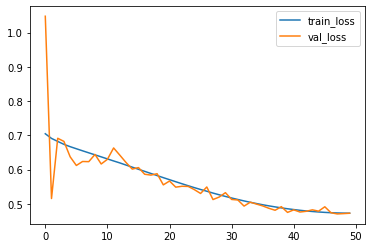

In [21]:
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend()

# Sample Inference

In [36]:
test_abstract1 = sample_train[0]['patent1abstract']
test_abstract2 = sample_train[0]['patent2abstract'] 

test1_input_id, test1_attention_mask, test1_length = BERT_Tokenizer(test_abstract1) 
test2_input_id, test2_attention_mask, test_length = BERT_Tokenizer(test_abstract2) 

test1_input_id = torch.tensor(test1_input_id, dtype=int)
test1_input_id = torch.reshape(test1_input_id, (1,512)) 
test1_input_id = test1_input_id.to(device)
test1_attention_mask = torch.tensor(test1_attention_mask, dtype=int) 
test1_attention_mask = torch.reshape(test1_attention_mask, (1,512))
test1_attention_mask = test1_attention_mask.to(device)

test2_input_id = torch.tensor(test2_input_id, dtype=int) 
test2_input_id = torch.reshape(test2_input_id, (1,512))
test2_input_id = test2_input_id.to(device)
test2_attention_mask = torch.tensor(test2_attention_mask, dtype=int) 
test2_attention_mask = torch.reshape(test2_attention_mask, (1,512)) 
test2_attention_mask = test2_attention_mask.to(device)

In [42]:
### load best checkpoint ### 
checkpoint = torch.load('BERT_ABSTRACT_47') 
test_model = BERT_ABSTRACT() 
test_model.cuda() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationsh

BERT_ABSTRACT(
  (bert1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [43]:
test_model.eval() 

with torch.no_grad(): 
    outputs = test_model(ids1=test1_input_id, 
                         masks1=test1_attention_mask, 
                         ids2=test2_input_id, 
                         masks2=test2_attention_mask) 

score = outputs.detach().cpu().numpy().flatten()[0]

print("Similarity Score = {}".format(score))

Similarity Score = 0.46026527881622314
